# Transfer Learning

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from tqdm.auto import tqdm

from going_modular import data_setup, engine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
import os
import zipfile

from pathlib import Path
import requests

DATA_PATH = Path("data/")
IMAGE_PATH = DATA_PATH / "pizza_steak_sushi"

if IMAGE_PATH.is_dir():
    print(f"{IMAGE_PATH} directory already exists")
else:
    IMAGE_PATH.mkdir(parents=True, exist_ok=True)

    with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        )
        print("Downloading...")
        f.write(request.content)

    with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping...")
        zip_ref.extractall(IMAGE_PATH)

os.remove(DATA_PATH / "pizza_steak_sushi.zip")

Downloading...
Unzipping...


In [14]:
TRAIN_DIR = IMAGE_PATH / "train"
TEST_DIR = IMAGE_PATH / "test"

In [76]:
manual_transorm = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=TRAIN_DIR, test_dir=TEST_DIR, transform=auto_transforms, batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f76a978350>,
 ['pizza', 'steak', 'sushi'])

In [18]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Chris/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 26.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [53]:
for param in model.features.parameters():
    param.requires_grad = False

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True),
).to(device)

In [54]:
summary(
    model,
    input_size=(
        32,
        3,
        224,
        224,
    ),  # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

NUM_EPOCHS = 5
start_time = timer()
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device,
)
end_time = timer()
print(f"[INFO] Total training time:  {end_time - start_time:.3f} seconds")

 20%|██        | 1/5 [00:25<01:40, 25.21s/it]

Epoch: 1 | train_loss: 1.0943 | train_acc: 0.3945 | test_loss: 0.9101 | test_acc: 0.5502


 40%|████      | 2/5 [00:41<00:59, 19.99s/it]

Epoch: 2 | train_loss: 0.8778 | train_acc: 0.7500 | test_loss: 0.7912 | test_acc: 0.8456


 60%|██████    | 3/5 [00:58<00:36, 18.42s/it]

Epoch: 3 | train_loss: 0.7561 | train_acc: 0.8086 | test_loss: 0.7481 | test_acc: 0.8456


 80%|████████  | 4/5 [01:14<00:17, 17.48s/it]

Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7461 | test_loss: 0.6417 | test_acc: 0.8655


100%|██████████| 5/5 [01:36<00:00, 19.34s/it]

Epoch: 5 | train_loss: 0.6228 | train_acc: 0.7891 | test_loss: 0.6290 | test_acc: 0.8759
[INFO] Total training time:  96.715 seconds


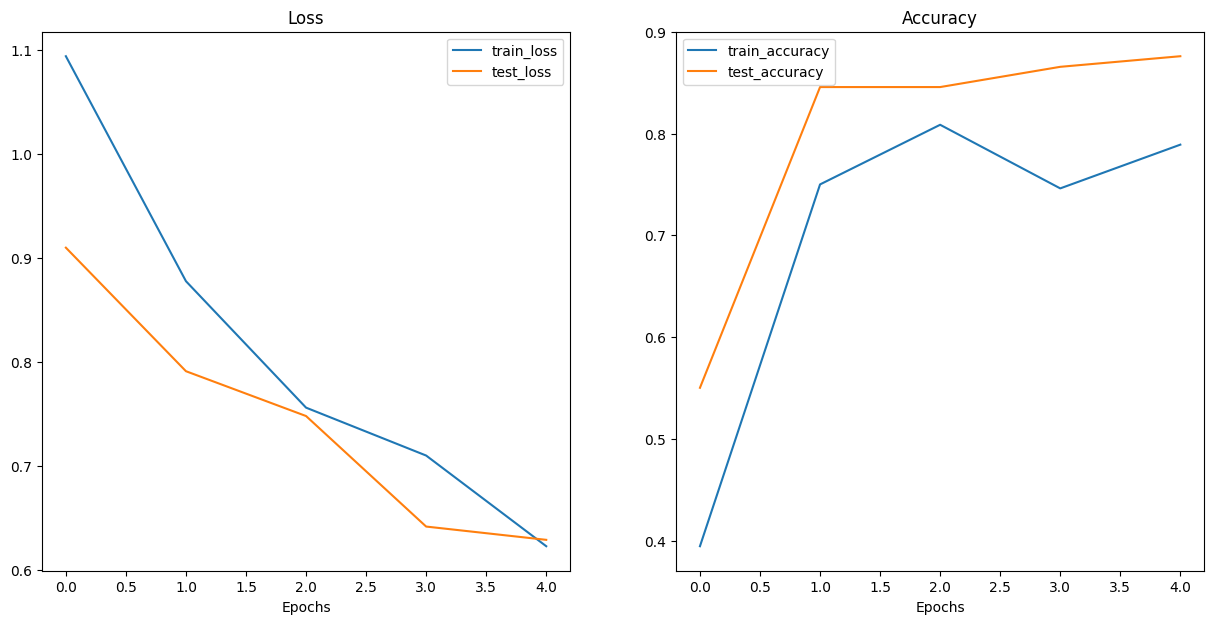

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

In [70]:
from typing import List, Tuple
from PIL import Image


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    img = Image.open(image_path)

    if transform is None:
        transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = transform(img).unsqueeze(dim=0)
        y_logits = model(transformed_img.to(device))

    y_probs = torch.softmax(y_logits, dim=1)
    label = torch.argmax(y_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"{class_names[label]}\nProb: {y_probs.max():.3f}")
    plt.axis(False)

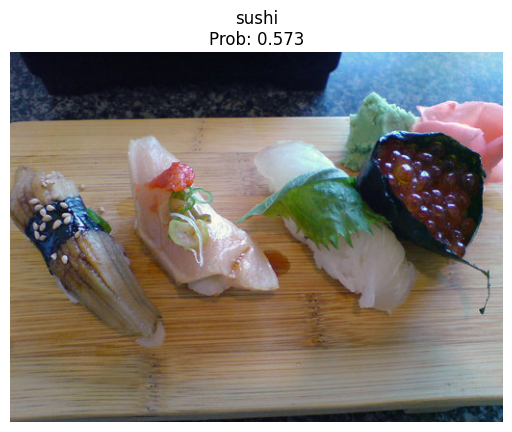

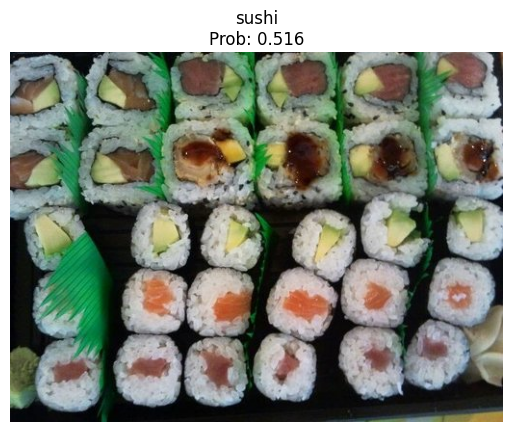

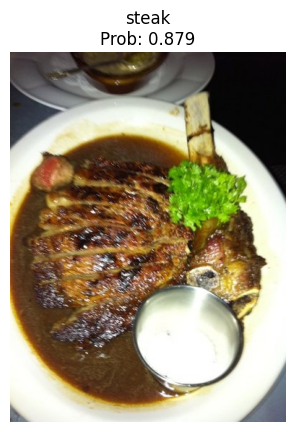

In [72]:
import random

test_image_path_list = list(Path(TEST_DIR).glob("*/*.jpg"))
random_image_path_sample = random.sample(test_image_path_list, k=3)

for image_path in random_image_path_sample:
    pred_and_plot_image(
        model=model,
        image_path=image_path,
        class_names=class_names,
        image_size=(224, 224),
    )

In [74]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = DATA_PATH / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
        )
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001F7F315DF70>: Failed to resolve 'raw.githubusercontent.com' ([Errno 11001] getaddrinfo failed)"))